In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Image data preprocessing

In [5]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/Users/chanju/github/mask_filtering_project/2주차/이찬주/LeeChanJu/data/train',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/Users/chanju/github/mask_filtering_project/2주차/이찬주/LeeChanJu/data/val",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1315 files belonging to 2 classes.
Using 1052 files for training.
Found 142 files belonging to 2 classes.
Using 28 files for validation.


visualize the data

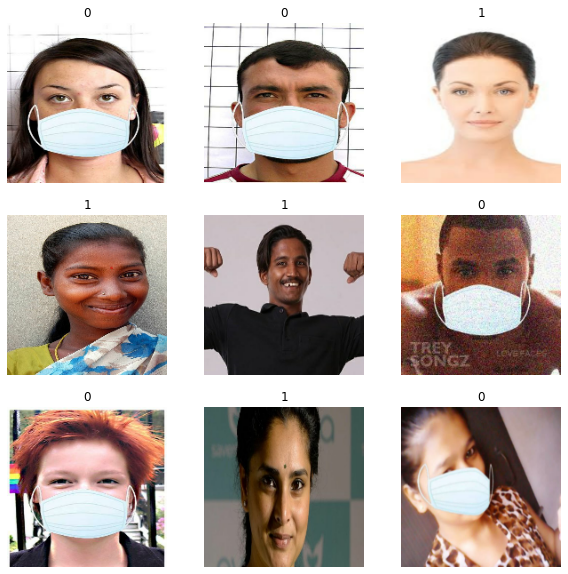

In [6]:
import matplotlib.pyplot as plt

# figure 크기를 조절합니다.
plt.figure(figsize=(10, 10))

# 배치 하나를 가져옵니다.
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Using Image data augmentation

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

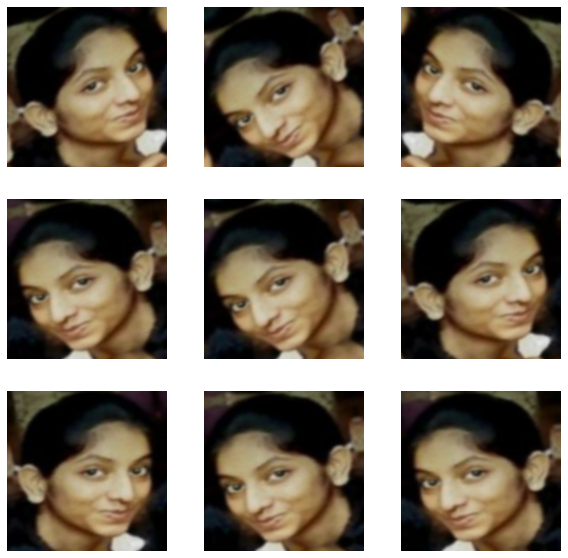

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [19]:
from keras.preprocessing.image import ImageDataGenerator

In [20]:
data_augmentation = ImageDataGenerator(rescale=1./255,
                                 rotation_range = 30,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=False,
                                 vertical_flip=False,
                                 fill_mode='nearest'
                                 )

ImageDataGenerator : 이미지 데이터 생성 // 전처리 + augmentation

trainDataGen = ImageDataGenerator(rescale=1./255,
                                 rotation_range = 30,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=False,
                                 vertical_flip=False,
                                 fill_mode='nearest'
                                 )



standardizing the data // rescale 0-255 to 0-1

augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [18]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # 본격적으로 모델에 입력하기 전에 여기서 augmentation이 진행됩니다.
    # inference time에는 동작하지 않습니다.
    x = data_augmentation(inputs)

    # [0, 1] 변환을 위해 Rescaling Layer를 활용합니다.
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    
    return keras.Model(inputs, outputs)

# image size에 (3, ) 채널을 추가합니다.
model = make_model(input_shape=image_size + (3,), num_classes=2)

TypeError: 'ImageDataGenerator' object is not callable